# Search Engine Competition 
Please run in the root directory, with Academic_Papers and General_Data folders in the root as well 

In [1]:
import json
import nltk
import numpy as np

import sklearn.ensemble
import sklearn.metrics
import matplotlib.pyplot as plt

import pyltr
import pickle 

/usr/lib64/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Num citations study

Does the number of citations affect the ranking of a paper?

In [2]:
'''
Raw documents, keyed by the docno
'''
citations={}

counter = 0
with open('Academic_papers/docs.json') as json_file:
    for line in json_file:
        if counter%1000 == 0:
            print(counter)
        paper = json.loads(line)
        doc_no = paper['docno']
        
        numCitedBy = paper['numCitedBy'][0]
        numKeyCitations = paper['numKeyCitations'][0]

        citations[doc_no] = [numCitedBy,numKeyCitations]
        
        counter +=1

0
1000
2000
3000
4000
5000
6000
7000
8000


In [3]:
rels=[]
citedBy=[]
keyCite=[]

with open('Academic_papers/train_queries_qrel') as file:
    for line in file: 
        counter+=1
        content = line.split(" ")
        qid=int(content[0])
        docid=content[1]
        rel=int(content[2].strip())
        
        try:
            citedBy.append(citations[docid][0])
            keyCite.append(citations[docid][1])
            rels.append(rel)
        except: 
            print("Error retrieving features for: " + docid)
#         key=qid+"_"+docid 
#         score = [0,0]
#         try:
#             score = all_features[key]
#         except:
#             print("Error retrieving features for: " + key)


Error retrieving features for: 76e282712f35424d160d801a72e48372ab891a50
Error retrieving features for: a62b58c267fddfa06545a7fc63a3c62ef7dc9e15
Error retrieving features for: 940b84cae7f8cef27351c7e0ff472cc3a80aff8c
Error retrieving features for: 1c40786dc5cc14efeb3a08e08bfdfdc52995b3ea
Error retrieving features for: 22ce15125f1c8fb466f241ce010e670d23dcc764
Error retrieving features for: d26a48aff2abc3460c1018d5b410766f698d696c
Error retrieving features for: 1721f5ee35869512f46035833ad1b6ad6346b2ad
Error retrieving features for: 16243557482241171beccbbd694976103cc941ef
Error retrieving features for: c72f5e1fa2eaa10933f0ffac95d323a80f50b00a
Error retrieving features for: 47225c992d7086cf5d113942212edb4a57401130
Error retrieving features for: 55136e0b6378e1b9c2738e3da6bdcf759c400dd3
Error retrieving features for: 051f689825d4f118a39a286cf72888d2d1a84438
Error retrieving features for: fcb42c401c36606216560118b4003dcd67bd5740
Error retrieving features for: 558c7e0fec15fee4de5d3a768725f9128

In [4]:
rels=np.asarray(rels)
keyCite=np.asarray(keyCite)
citedBy=np.asarray(citedBy)

In [58]:
print("Relevance:\tAverage Key Citations\tMedian")
for i in range(0, 5):
    print(str(i)+":\t\t" + str(np.average(keyCite[np.where(rels==i)])) + "\t" + str(np.median(keyCite[np.where(rels==i)])))

Relevance:	Average Key Citations	Median
0:		24.99238095238095	2.0
1:		6.883660130718955	1.0
2:		16.73170731707317	4.0
3:		35.440993788819874	14.0
4:		151.13513513513513	51.0


In [59]:
print("Relevance:\tAverage Num Citations\tMedian")
for i in range(0, 5):
    print(str(i)+":\t\t" + str(np.average(citedBy[np.where(rels==i)])) + "\t"+ str(np.median(citedBy[np.where(rels==i)])))

Relevance:	Average Num Citations	Median
0:		330.0730158730159	58.0
1:		100.0562091503268	25.0
2:		236.84552845528455	82.0
3:		529.6583850931677	215.0
4:		1822.5405405405406	1088.0


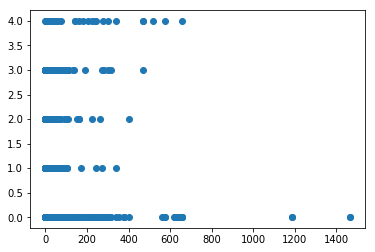

In [31]:
plt.scatter(keyCite,rels)

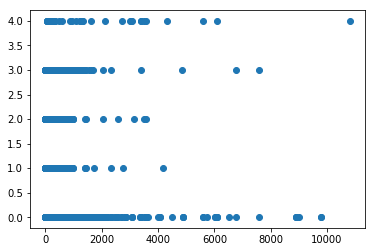

In [32]:
plt.scatter(citedBy,rels)

## Process the JSON files (for Academic papers)
Available JSON keys: 
* keyPhrases
* paperAbstract
* numKeyReferences
* title
* venue
* numCitedBy
* numKeyCitations
* docno
* ana

In [10]:
'''
Raw documents, keyed by the docno
'''
docs={}

counter = 0
with open('Academic_papers/docs.json') as json_file:
    for line in json_file:
        if counter%1000 == 0:
            print(counter)
        paper = json.loads(line)
        content = ''
        doc_no = paper['docno']
        try:
             content += ' '.join(paper['keyPhrases']) + ''
        except:
             pass
        try:
             content += ' '.join(paper['title']) + ''
        except:
            pass
        try:
            content += ' '.join(paper['paperAbstract']) + ''
        except:
            pass
        try:
            content += ' '.join(paper['venue']) + ''
        except:
            pass
        
        docs[doc_no] = content
        
        counter +=1

0
1000
2000
3000
4000
5000
6000
7000
8000


## Preprocess the documents 

#### FIRST, your data needs to be in this format: {paper_id: document} 

* Tokenize, lowercase
* Remove stopwords

Potential improvements here:
* Lemmatize/stem? 

In [3]:
stopwords={}
with open('General_data/lemur-stopwords.txt') as file:
    for line in file:
        stopwords[line.strip()] = 1

In [4]:
'''
Returns array
'''
def preprocess_doc(doc):
    words = nltk.word_tokenize(doc)
    good_words=[]
    for w in words:
        w = w.lower()
        if w not in stopwords:
            good_words.append(w)
    return good_words

## BM25 initialization
https://en.wikipedia.org/wiki/Okapi_BM25

Variables
* `N` is number of documents in the collection
* `n` stores how many documents each word in the collection appears in
* `freq(qi, D)` computes the term frequency of each document (this is stored in `tf`, and the term frequency of one document can be accessed using `tf[doc_id]`)
* `doc_lens` is |D|, which is the length of each document (AFTER it has been preprocessed) 
* `IDF()` computes the IDF of each query word


Note: D will represent the 'doc_no' or 'doc_id' 


Constant variables 
* `k1` = 1.2
* `b` = 0.75

Potential improvements here:
* Experiment with the different k1 values 


In [5]:
N=len(docs)
k1=1.2
b = 0.75

In [6]:
# get avgdl 
avgdl = 0
for d in docs:
    avgdl+=len(docs[d])
    
avgdl=avgdl/N

In [7]:
# term freqencies for every document 
tf={}

# number of documents containing a word
n = {}
counter = 0
for key in docs:
    if counter %1000 == 0:
        print(counter)
    counter += 1
    tf[key] = {}

    # all the words in a document
    terms = preprocess_doc(docs[key])
    
    uniq=set()
    
    for term in terms:
        uniq.add(term)
        if term not in tf[key]:
            tf[key][term] = 1
        else:
            tf[key][term] +=1
    for u in uniq:
        if u not in n:
            n[u] = 1
        else:
            n[u] += 1

0
1000
2000
3000
4000
5000
6000
7000
8000


In [8]:
doc_lens = {}
for paper in tf:
    count = 0
    for word in tf[paper]:
        count += tf[paper][word]
    doc_lens[paper] = count

In [9]:
query = ['deep', 'learning']
query = ['information', 'retrieval']

In [10]:
def IDF(qi):
    nqi = 0
    if qi in n:
        nqi = n[qi]
    num=N-nqi + 0.5
    denom = nqi + 0.5
    return np.log(num/denom)

In [11]:
def freq(qi, D):
    if qi in tf[D]:
        return tf[D][qi]
    else:
        return 0

In [165]:
docs['0ddc065cc92046857d35555c3af4ade1310aca4a']

u'Shortterm Context Ranking Function EST Implicit Feed Implicit FeedbackContext-sensitive information retrieval using implicit feedbackA major limitation of most existing retrieval models and systems is that the retrieval decision is made based solely on the query and document collection; information about the actual user and search context is largely ignored. In this paper, we study how to exploit implicit feedback information, including previous queries and clickthrough information, to improve retrieval accuracy in an interactive information retrieval setting. We propose several context-sensitive retrieval algorithms based on statistical language models to combine the preceding queries and clicked document summaries with the current query for better ranking of documents. We use the TREC AP data to create a test collection with search context information, and quantitatively evaluate our models using this test set. Experiment results show that using implicit feedback, especially the cl

## Test BM25


In [28]:
# get queries 
# qid, ana, query

'''
Raw documents, keyed by the docno
'''
test_queries={}

counter = 0
with open('Academic_papers/test_queries.json') as json_file:
    for line in json_file:
        line = json.loads(line)
        query = line['query'].split(" ")
        test_queries[line['qid']]= query

In [13]:
docid='5c98b6ca32c72c50aa55a7038d0e15176bdd15b5'
def bm25(D, Q):
    score = 0
    for qi in Q:
        num = freq(qi, D) *(k1+1)
        denom = freq(qi, D) + k1 * (1 - b + b * (doc_lens[D]/avgdl))
        score+=(IDF(qi)*(num/denom))
    return score


In [14]:
# each index is the query id
results = []

for qid in queries:
    res = []
    for D in docs:
        score = bm25(D, queries[qid])
#        if score > 0:
        res.append((D, score))
    results.append(res)

## Get features for supervision

In [163]:
def get_raw_bm25_features(query_json):
    '''
    Raw documents, keyed by the docno
    '''
    queries={}

    counter = 0
    with open(query_json) as json_file:
        for line in json_file:
            line = json.loads(line)
            query = line['query'].split(" ")
            queries[line['qid']]= query

    results = []

    for qid in queries:
        res = []
        for D in docs:
            score = bm25(D, queries[qid])
    #        if score > 0:
            res.append((D, score))
        results.append(res)
        
    
    features={}
    for qid, res in enumerate(results):
    #     print(qid)
        for doc in res:
            key=str(qid)+"_"+doc[0]
            score=doc[1]
            features[key] = score
            
    return features
    

In [126]:
## getting metapy okapi bm25 features 

def get_features_from_file(filename):
    '''
    parameters:
    - filename contains scores in the following format: qid, docid, score 
    
    output:
    - features is keyed by qid_docid, and the value stored is score 
    '''
    # key is qid_docid 
    features={}
    with open(filename) as file:
        for line in file: 
            content = line.split("\t")
            qid=content[0]
            docid=content[1]
            key=qid+"_"+docid

            score=float(content[2].strip())

            features[key] = [score]

        return features
        

In [106]:
def get_two_features_from_files(file1, file2):
    '''
    parameters:
    - file1 and file2 contain scores in the following format: qid, docid, score 
    - file1 is bm25
    - file2 is absolute discounting 
    
    
    output:
    - features is keyed by qid_docid, and the value stored is score 
    '''
    # key is qid_docid 
    features={}
    with open(file1) as file:
        for line in file: 
            content = line.split("\t")
            qid=content[0]
            docid=content[1]
            key=qid+"_"+docid

            score=float(content[2].strip())

            features[key] = [score]

            
    with open(file2) as file:
        for line in file: 
            content = line.split("\t")
            qid=content[0]
            docid=content[1]
            key=qid+"_"+docid

            score=float(content[2].strip())
            
            try: 
                features[key].append(score)
            except:
                print("Error getting key: " + key)

            
    
            
    return features

In [137]:
# all_features=get_two_features_from_files('all_academic_train_results.txt','all_academic_train_results_absolute_discounting')
# all_test_features=get_two_features_from_files('all_academic_test_results.txt','all_academic_test_results_absolute_discounting')
# bm25_features=get_features_from_file('all_academic_train_results.txt')
# test_bm25_features=get_features_from_file('all_academic_test_results.txt')

In [7]:
def get_four_features(file1, file2):
    '''
    parameters:
    - file1 and file2 contain scores in the following format: qid, docid, score 
    - file1 is bm25
    - file2 is absolute discounting 
    
    
    output:
    - features is keyed by qid_docid, and the value stored is score 
    '''
    # key is qid_docid 
    features={}
    with open(file1) as file:
        for line in file: 
            content = line.split("\t")
            qid=content[0]
            docid=content[1]
            key=qid+"_"+docid

            score=float(content[2].strip())

            features[key] = [score]

            
    with open(file2) as file:
        for line in file: 
            content = line.split("\t")
            qid=content[0]
            docid=content[1]
            key=qid+"_"+docid

            score=float(content[2].strip())
            
            cited_by=0
            key_citations=0
            
            try: 
                features[key].append(score)
                
                #appending citations as features
                try:              
                    cited_by=citations[docid][0]
                    key_citations=citations[docid][1]

                    features[key].append(cited_by)
                    features[key].append(key_citations)
                except:
                    print("Error getting docid for citations: " + docid)
            except:
                print("Error getting key: " + key)
            
            
  

            
    
            
    return features

In [8]:
all_features=get_four_features('all_academic_train_results.txt','all_academic_train_results_absolute_discounting')
all_test_features=get_four_features('all_academic_test_results.txt','all_academic_test_results_absolute_discounting')

In [11]:
# get queries 
# qid, ana, query

'''
Raw documents, keyed by the docno
'''
test_queries={}

counter = 0
with open('Academic_papers/test_queries.json') as json_file:
    for line in json_file:
        line = json.loads(line)
        query = line['query'].split(" ")
        test_queries[line['qid']]= query

## get into format for supervised training 

test_X = []
test_doc_labels = []

for qid in test_queries:
    for D in docs:
        key=str(qid)+"_"+D
        score=[0,0]
        try:
            score= all_test_features[key]
        except:
            #print("Error retrieving key: " + key)
            pass
        
        test_X.append(score)
        test_doc_labels.append(key)

## Try Supervised Methods (learning-to-rank) for Academic
We are going to store the content as features instead of one text 

In [13]:
counter = 0
# feature vector, currently only has bm25 value 
X = []
# relevance judgments (labels)
y = []
# order of the features and labels
doc_labels=[]

#q_id, doc_id, relevance from 0-4
with open('Academic_papers/train_queries_qrel') as file:
    for line in file: 
        if counter%500 == 0:
            print(counter)
        counter+=1
        content = line.split(" ")
        qid=content[0]
        docid=content[1]
        rel=int(content[2].strip())
        
        key=qid+"_"+docid 
        score = [0,0,0,0]
        try:
            score = all_features[key]
        except:
            print("Error retrieving features for: " + key)
        
        X.append(score)
        doc_labels.append(key)
        y.append(rel)

        

0
Error retrieving features for: 0_76e282712f35424d160d801a72e48372ab891a50
Error retrieving features for: 0_a62b58c267fddfa06545a7fc63a3c62ef7dc9e15
Error retrieving features for: 0_940b84cae7f8cef27351c7e0ff472cc3a80aff8c
Error retrieving features for: 0_1c40786dc5cc14efeb3a08e08bfdfdc52995b3ea
Error retrieving features for: 0_22ce15125f1c8fb466f241ce010e670d23dcc764
Error retrieving features for: 0_d26a48aff2abc3460c1018d5b410766f698d696c
Error retrieving features for: 0_1721f5ee35869512f46035833ad1b6ad6346b2ad
Error retrieving features for: 0_16243557482241171beccbbd694976103cc941ef
Error retrieving features for: 0_c72f5e1fa2eaa10933f0ffac95d323a80f50b00a
Error retrieving features for: 0_47225c992d7086cf5d113942212edb4a57401130
Error retrieving features for: 0_55136e0b6378e1b9c2738e3da6bdcf759c400dd3
Error retrieving features for: 0_051f689825d4f118a39a286cf72888d2d1a84438
Error retrieving features for: 0_fcb42c401c36606216560118b4003dcd67bd5740
Error retrieving features for: 0_558

In [104]:
# sk_model=sklearn.ensemble.GradientBoostingClassifier(learning_rate=0.002, 
#                                            n_estimators=1000,
#                                            min_samples_leaf=64,
#                                            max_leaf_nodes=10,
#                                            verbose=1,
#                                            max_features=0.5)
# X=np.asarray(X)
# y=np.asarray(y)
# sk_model.fit(X, y)
# pred=sk_model.predict(X)
# test_pred=sk_model.predict(test_X)
# np.where(pred!=0)
# plt.hist(test_pred.astype(int))

## LambdaMART implementation via pyltr...

Issue is the output is regression values and not sure how to map it back to class labels. 

But, perhaps, we can just use the regression values as a score to rank?

In [107]:
all_features=get_two_features_from_files('all_academic_train_results.txt','all_academic_train_results_absolute_discounting')
all_test_features=get_two_features_from_files('all_academic_test_results.txt','all_academic_test_results_absolute_discounting')

In [108]:
#first, get data into the correct format for pyltr: LambdaMART 
#each row is a doc, query pair. 
#columns are: relevance (label), qid:123, features..., #comments (i.e., doc_id)

qids=[]
for i in doc_labels:
    qids.append(int(i.split("_")[0]))

### Split into train and test!!

In [38]:
# train test split 
np.random.seed(69)
ii = np.random.rand(len(X)) < 0.7 

In [51]:
X_train = X[ii]
X_test = X[~ii]
y_train = y[ii]
y_test = y[~ii]
qids_train = qids[ii]
qids_test = qids[~ii]

ii_v=np.random.rand(len(X_test)) < 0.5
X_t=X_test[ii_v]
y_t=y_test[ii_v]
qids_t=qids_test[ii_v]

X_validation=X_test[~ii_v]
y_validation=y_test[~ii_v]
qids_validation=qids_test[~ii_v]

In [65]:
# calculate ndcg for first _k_ items 
metric = pyltr.metrics.NDCG(k=50)

# Only needed if you want to perform validation (early stopping & trimming)
monitor = pyltr.models.monitors.ValidationMonitor(
    X_validation, y_validation, qids_validation, metric=metric, stop_after=100)

model = pyltr.models.LambdaMART(
    metric=metric,
    n_estimators=1000,
    learning_rate=0.008,
    max_features=0.3,
    query_subsample=0.5,
    max_leaf_nodes=10,
    min_samples_leaf=64,
    verbose=1,
    warm_start=False,
)

model.fit(X_train, y_train, qids_train, monitor=monitor)

 Iter  Train score  OOB Improve    Remaining                           Monitor Output 
    1       0.5145       0.1705        6.00m      C:      0.2913 B:      0.2913 S:  0
    2       0.5772       0.0179        7.09m      C:      0.2929 B:      0.2929 S:  0
    3       0.6441       0.0652        7.24m      C:      0.3094 B:      0.3094 S:  0
    4       0.6597       0.0462        6.83m      C:      0.3136 B:      0.3136 S:  0
    5       0.7034       0.0255        6.95m      C:      0.3112 B:      0.3136 S:  1
    6       0.7067      -0.0040        6.68m      C:      0.3242 B:      0.3242 S:  0
    7       0.6865      -0.0371        6.46m      C:      0.3236 B:      0.3242 S:  1
    8       0.7220       0.0185        6.57m      C:      0.3316 B:      0.3316 S:  0
    9       0.7135      -0.0020        6.45m      C:      0.3322 B:      0.3322 S:  0
   10       0.7122       0.0029        6.65m      C:      0.3213 B:      0.3322 S:  1
   15       0.7026      -0.0024        6.35m      C: 

In [66]:
X_train=np.asarray(X_train)
y_train=np.asarray(y_train)
qids_train=np.asarray(qids_train)

In [67]:
print("Training results: ")
train_pred = model.predict(X_train)
print 'Random ranking:', metric.calc_mean_random(qids_train, y_train)
print 'Our model:', metric.calc_mean(qids_train, y_train, train_pred.reshape(len(train_pred),1))
print("Testing results: ")
test_pred = model.predict(X_t)
print 'Random ranking:', metric.calc_mean_random(qids_t, y_t)
print 'Our model:', metric.calc_mean(qids_t, y_t, test_pred.reshape(len(test_pred),1))

Training results: 
Random ranking: 0.52253225252609
Our model: 0.7523145709203806
Testing results: 
Random ranking: 0.2383437970905155
Our model: 0.32195136053896783


In [80]:
# calculate ndcg for first _k_ items 
metric = pyltr.metrics.NDCG(k=50)

# Only needed if you want to perform validation (early stopping & trimming)
# monitor = pyltr.models.monitors.ValidationMonitor(
#     VX, Vy, Vqids, metric=metric, stop_after=50)

model = pyltr.models.LambdaMART(
    metric=metric,
    n_estimators=1000,
    learning_rate=0.02,
    max_features=0.5,
    query_subsample=0.5,
    max_leaf_nodes=10,
    min_samples_leaf=64,
    verbose=1,
    warm_start=False,
)

model.fit(X, y, qids)

 Iter  Train score  OOB Improve    Remaining                           Monitor Output 
    1       0.5741       0.3269       15.65m                                         
    2       0.6191       0.0293       14.74m                                         
    3       0.6070       0.0064       14.92m                                         
    4       0.6953       0.0275       13.60m                                         
    5       0.6385      -0.0009       13.46m                                         
    6       0.6420       0.0039       13.39m                                         
    7       0.6832      -0.0039       13.25m                                         
    8       0.6719      -0.0015       13.03m                                         
    9       0.7020       0.0010       12.97m                                         
   10       0.6726       0.0011       13.04m                                         
   15       0.7321       0.0004       12.63m         

In [112]:
X=np.asarray(X)
y=np.asarray(y)
qids=np.asarray(qids)

In [113]:
print("Training results: ")
train_pred = model.predict(X)
print 'Random ranking:', metric.calc_mean_random(qids, y)
print 'Our model:', metric.calc_mean(qids, y, train_pred.reshape(len(train_pred),1))

Training results: 
Random ranking: 0.47804440644999857
Our model: 0.8103062159117261


In [131]:
test_pred = model.predict(test_X)

In [60]:
print("Training results: ")
train_pred = model.predict(X_train)
print 'Random ranking:', metric.calc_mean_random(qids_train, y_train)
print 'Our model:', metric.calc_mean(qids_train, y_train, train_pred.reshape(len(train_pred),1))

Training results: 
Random ranking: 0.52253225252609
Our model: 0.7530571368296105


In [61]:
print("Testing results: ")
test_pred = model.predict(X_t)
print 'Random ranking:', metric.calc_mean_random(qids_t, y_t)
print 'Our model:', metric.calc_mean(qids_t, y_t, test_pred.reshape(len(test_pred),1))

Testing results: 
Random ranking: 0.2383437970905155
Our model: 0.3223287546801509


In [22]:
print(np.max(train_pred))
print(np.min(train_pred))

1.093795238116922
-1.0022610215176444


(array([2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.753e+03,
        0.000e+00, 0.000e+00, 0.000e+00, 2.700e+01]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

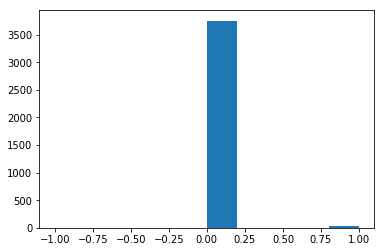

In [23]:
plt.hist(train_pred.astype(int))

In [24]:
test_X=np.asarray(test_X)

([array([3782.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.]),
  array([3782.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.]),
  array([3.609e+03, 9.400e+01, 3.200e+01, 2.000e+01, 5.000e+00, 1.000e+01,
         3.000e+00, 2.000e+00, 4.000e+00, 3.000e+00]),
  array([3778.,    4.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.])],
 array([-5.65596390e+00,  1.07610963e+03,  2.15787523e+03,  3.23964083e+03,
         4.32140642e+03,  5.40317202e+03,  6.48493761e+03,  7.56670321e+03,
         8.64846881e+03,  9.73023440e+03,  1.08120000e+04]),
 <a list of 4 Lists of Patches objects>)

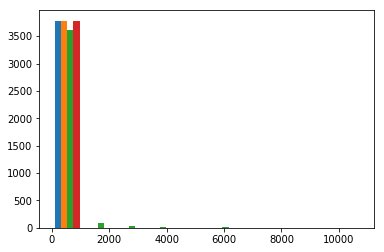

In [25]:
plt.hist(X)

In [73]:
test_pred=model.predict(test_X)

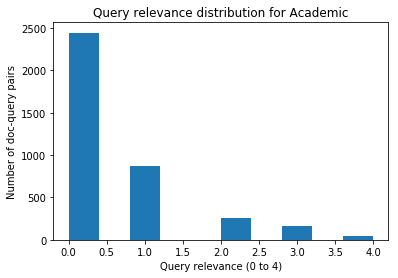

In [130]:
plt.hist(y)
plt.title('Query relevance distribution for Academic')
plt.ylabel('Number of doc-query pairs')
plt.xlabel('Query relevance (0 to 4)')

(array([1.2407e+04, 8.8052e+04, 4.9962e+04, 1.5134e+04, 4.5600e+03,
        5.0100e+02, 1.0700e+02, 6.1000e+01, 2.3000e+01, 1.3000e+01]),
 array([-4.95155859, -4.14583312, -3.34010765, -2.53438218, -1.72865671,
        -0.92293124, -0.11720577,  0.6885197 ,  1.49424517,  2.29997064,
         3.10569611]),
 <a list of 10 Patch objects>)

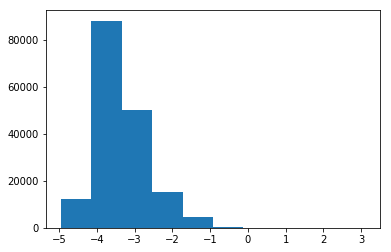

In [115]:
plt.hist(test_pred)

In [102]:
pred_dict = [[] for i in range(20)]

for idx, key in enumerate(test_doc_labels):
    temp=key.split("_")
    qid=int(temp[0])
    docid=temp[1]
    
    pred_dict[qid].append([docid,test_pred[idx]])
    
    
f = open("academic_results_4_features_validation.txt", "a")
for q_id, q in enumerate(pred_dict):
    my_scores = sorted(q, key = lambda x: x[1], reverse=True)
    for i in range(0,100):
        try:
            res = my_scores[i]        
            f.write(str(q_id) + "\t" + str(res[0]) + "\t" + str(res[1]) + "\n")
        except:
            pass

f.close()

# LambdaMART for General dataset

In [127]:
general_bm25_features =get_two_features_from_files('all_train_general.txt','all_general_train_results_absolute_discounting.txt')
test_general_bm25_features =get_two_features_from_files('all_test_general.txt','all_general_test_results_absolute_discounting.txt')

In [26]:
with open('general_bm25_features_all.pickle', 'wb') as f:
    pickle.dump(general_bm25_features, f)

### Test features

In [128]:
"""
This function parses xml query files
"""
import xml.etree.ElementTree as ET
def parseXMLqueries(filename):
    # parses the queries for list of queries
    tree = ET.parse(filename)
    res = []
    for elem in tree.findall('query'):
        res.append(elem.find('text').text[10:-2])
    return res

queries = parseXMLqueries('General_data/testqueries.xml')

In [129]:
docs = {}
with open('General_data/train_qrel') as file:
    for line in file:
        temp=line.split(" ")
        docid=temp[1]
        
        docs[docid] = ""

In [84]:
'''
Raw documents, keyed by the docno
'''
counter = 0
# feature vector, currently only has bm25 value 
X = []
# relevance judgments (labels)
y = []
# order of the features and labels
doc_labels=[]

#q_id, doc_id, relevance from 0-4
with open('General_data/train_qrel') as file:
    for line in file: 
        content = line.split(" ")
        qid=content[0]
        docid=content[1]
        rel=int(content[2].strip())
        
        key=qid+"_"+docid 
        score = [0]
        try:
            score = general_bm25_features[key]
        except:
            pass
            #print("Error retrieving features for: " + key)
        
        X.append(score)
        doc_labels.append(key)
        y.append(rel)

In [139]:
# get queries 
# qid, ana, query

'''
Raw documents, keyed by the docno
'''
test_queries={}

counter = 0
for qid,query in enumerate(queries):
    test_queries[qid]= query

## get into format for supervised training 

test_X = []
test_doc_labels = []

for qid in test_queries:
    for D in docs:
        key=str(qid)+"_"+D
        score=[0]
        try:
            score= test_general_bm25_features[key]
        except:
            #print("Error retrieving key: " + key)
            pass
        
        test_X.append(score)
        test_doc_labels.append(key)

In [142]:
qids=[]
for i in doc_labels:
    qids.append(int(i.split("_")[0]))

In [144]:
X=np.asarray(X)
y=np.asarray(y)

In [82]:
# calculate ndcg for first _k_ items 
metric = pyltr.metrics.NDCG(k=20)

# Only needed if you want to perform validation (early stopping & trimming)
# monitor = pyltr.models.monitors.ValidationMonitor(
#     VX, Vy, Vqids, metric=metric, stop_after=50)

model = pyltr.models.LambdaMART(
    metric=metric,
    n_estimators=1000,
    learning_rate=0.002,
    max_features=0.5,
    query_subsample=0.5,
    max_leaf_nodes=10,
    min_samples_leaf=64,
    verbose=1,
    warm_start=False,
)

model.fit(X, y, qids)

In [159]:
train_pred=np.asarray(train_pred)
qids=np.asarray(qids)
y=np.asarray(y)

In [147]:
train_pred = model.predict(X)

train_pred=np.asarray(train_pred)
print 'Random ranking:', metric.calc_mean_random(qids, y)
print 'Our model:', metric.calc_mean(qids, y, train_pred)

Random ranking: 0.053050271636251624
Our model: 0.4250906200751639


In [ ]:
print(np.max(train_pred))
print(np.min(train_pred))
plt.hist(train_pred.astype(int))

In [46]:
with open('general_all_test_X.pickle', 'wb') as f:
    pickle.dump(test_X, f)

with open('general_all_test_doc_labels.pickle', 'wb') as f:
    pickle.dump(test_doc_labels, f)

In [70]:
test_pred=model.predict(test_X)

(array([9.4744e+04, 5.2027e+04, 1.0676e+04, 7.4590e+03, 5.4460e+03,
        2.0800e+02, 1.2900e+02, 8.2000e+01, 3.2000e+01, 1.7000e+01]),
 array([-1.55549212, -1.25825859, -0.96102506, -0.66379154, -0.36655801,
        -0.06932448,  0.22790905,  0.52514257,  0.8223761 ,  1.11960963,
         1.41684315]),
 <a list of 10 Patch objects>)

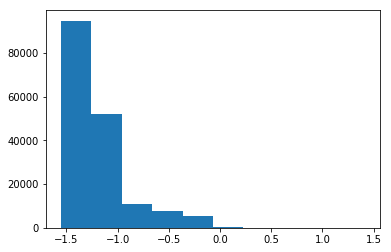

In [71]:
plt.hist(test_pred)

In [152]:
pred_dict = [[] for i in range(len(queries))]

for idx, key in enumerate(test_doc_labels):
    temp=key.split("_")
    qid=int(temp[0])
    docid=temp[1]
    
    pred_dict[qid].append([docid,test_pred[idx]])
    
    

f = open("general_results_all_ndcg20_est500_0.02.txt", "a")
for q_id, q in enumerate(pred_dict):
    my_scores = sorted(q, key = lambda x: x[1], reverse=True)
    for i in range(0,100):
        try:
            res = my_scores[i]        
            f.write(str(q_id) + "\t" + str(res[0]) + "\t" + str(res[1]) + "\n")
        except:
            pass

f.close()

# Evaluation Metrics 

In [116]:
import numpy as np

def dcg_at_k(r, k, method=0):
    """Score is discounted cumulative gain (dcg)
    Relevance is positive real values.  Can use binary
    as the previous methods.
    Example from
    http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
    >>> r = [3, 2, 3, 0, 0, 1, 2, 2, 3, 0]
    >>> dcg_at_k(r, 1)
    3.0
    >>> dcg_at_k(r, 1, method=1)
    3.0
    >>> dcg_at_k(r, 2)
    5.0
    >>> dcg_at_k(r, 2, method=1)
    4.2618595071429155
    >>> dcg_at_k(r, 10)
    9.6051177391888114
    >>> dcg_at_k(r, 11)
    9.6051177391888114
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
        method: If 0 then weights are [1.0, 1.0, 0.6309, 0.5, 0.4307, ...]
                If 1 then weights are [1.0, 0.6309, 0.5, 0.4307, ...]
    Returns:
        Discounted cumulative gain
    """
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.


def ndcg_at_k(r, k, method=0):
    """Score is normalized discounted cumulative gain (ndcg)
    Relevance is positive real values.  Can use binary
    as the previous methods.
    Example from
    http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
    >>> r = [3, 2, 3, 0, 0, 1, 2, 2, 3, 0]
    >>> ndcg_at_k(r, 1)
    1.0
    >>> r = [2, 1, 2, 0]
    >>> ndcg_at_k(r, 4)
    0.9203032077642922
    >>> ndcg_at_k(r, 4, method=1)
    0.96519546960144276
    >>> ndcg_at_k([0], 1)
    0.0
    >>> ndcg_at_k([1], 2)
    1.0
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
        method: If 0 then weights are [1.0, 1.0, 0.6309, 0.5, 0.4307, ...]
                If 1 then weights are [1.0, 0.6309, 0.5, 0.4307, ...]
    Returns:
        Normalized discounted cumulative gain
    """
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max

In [117]:
queries={}
qrels={}

with open('Academic_papers/train_queries_qrel') as file:
#with open(qrel_file) as file:
    for line in file: 
        content = line.split(" ")
        qid=content[0]
        docid=content[1]
        rel=int(content[2].strip())

        if qid not in queries:
            queries[qid] = ''

        key=qid+'_'+docid 
        qrels[key]=rel

In [121]:
train_pred_dict = [[] for i in range(len(queries))]

for idx, key in enumerate(doc_labels):
    temp=key.split("_")
    qid=int(temp[0])
    docid=temp[1]
    train_pred_dict[qid].append([docid,train_pred[idx]])
    
f = open("academic_metrics_train_results.txt", "a")
for q_id, q in enumerate(train_pred_dict):
    my_scores = sorted(q, key = lambda x: x[1], reverse=True)
    for i in range(0,100):
        try:
            res = my_scores[i]        
            f.write(str(q_id) + "\t" + str(res[0]) + "\t" + str(res[1]) + "\n")
        except:
            pass

f.close()

In [122]:
pred_rels = [[] for i in range(len(queries))]

# these should be the results you want to calculate! 
with open('academic_metrics_train_results.txt') as file:
    for line in file: 
        score=0

        content = line.split("\t")
        qid=content[0]
        docid=content[1]
        key=qid+'_'+docid 

        rel=float(content[2].strip())
        qid=int(qid)

        try:
            pred_rels[qid].append(qrels[key])
            #print(str(qid) + "\t" + str(qrels[key]))
        except:
            pred_rels[qid].append(0)


for n in [5,10,20,50,100]:
    avg_ndcg = 0
    for i in range(len(queries)):
        avg_ndcg+=ndcg_at_k(pred_rels[i],n, method=1)
    avg_ndcg=avg_ndcg/len(queries)
    print("NDCG@"+str(n)+":\t"+str(avg_ndcg))

NDCG@5:	0.5964252655586929
NDCG@10:	0.5585314727171288
NDCG@20:	0.5326177153969958
NDCG@50:	0.5979077052309287
NDCG@100:	0.6730005047511504
